In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import os.path

import scipy,scipy.spatial
import matplotlib
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/ucsd-cse-251b-class-competition.zip ./drive/MyDrive/CSE251B/

cp: cannot stat '/content/ucsd-cse-251b-class-competition.zip': No such file or directory


In [ ]:
drive.flush_and_unmount()

In [ ]:
!cp ./weights.w ./drive/MyDrive/CSE251B/

In [ ]:
!cp ./drive/MyDrive/CSE251B/ucsd-cse-251b-class-competition.zip ./
!unzip ucsd-cse-251b-class-competition.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/98379.pkl   
  inflating: train/train/9838.pkl    
  inflating: train/train/98380.pkl   
  inflating: train/train/98381.pkl   
  inflating: train/train/98382.pkl   
  inflating: train/train/98383.pkl   
  inflating: train/train/98384.pkl   
  inflating: train/train/98385.pkl   
  inflating: train/train/98386.pkl   
  inflating: train/train/98387.pkl   
  inflating: train/train/98388.pkl   
  inflating: train/train/98389.pkl   
  inflating: train/train/9839.pkl    
  inflating: train/train/98390.pkl   
  inflating: train/train/98391.pkl   
  inflating: train/train/98392.pkl   
  inflating: train/train/98393.pkl   
  inflating: train/train/98394.pkl   
  inflating: train/train/98395.pkl   
  inflating: train/train/98396.pkl   
  inflating: train/train/98397.pkl   
  inflating: train/train/98398.pkl   
  inflating: train/train/98399.pkl   
  inflating: train/train/984.pkl     
  inflating: train/train/9840.pkl    

In [ ]:
!cp ./drive/MyDrive/CSE251B/weights.w ./

### model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
 This notebook uses train as an example.
 Change to the val folder for evaluation 
"""

new_path = "./train/train"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
data  = ArgoverseDataset(data_path=new_path)



In [ ]:
def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]

    inp = torch.LongTensor(inp).to(device)
    out = torch.LongTensor(out).to(device)
    return [inp, out]

In [ ]:
data_extracted = []
for i in data:
  data_extracted.append(i)

KeyboardInterrupt: ignored

In [ ]:
data_extracted[0]

In [ ]:
X = []
y = []
for i in data:
    mask = i['car_mask']
    inp = numpy.dstack([i['p_in'], i['v_in']])
    out = numpy.dstack([i['p_out'], i['v_out']])
    #print(out.shape)
    for j in range(len(mask)):
      if mask[j][0]==1:
        X.append(inp[j])
        y.append(out[j][0])

    #inp = numpy.stack( inp, axis=0 )

In [ ]:
X = np.stack(X,axis=0)
print(X.shape)
y = np.stack(y,axis=0)
print(y.shape)

(1812171, 19, 4)
(1812171, 4)


In [ ]:
data_extracted = []

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

In [ ]:
batch_sz = 128

def my_collate(batch):

    return torch.LongTensor(batch).to(device)

#train_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)
dataset = TensorDataset( Tensor(X), Tensor(y) )
split_number = int(len(X)*0.8)
train_idx = [i for i in range(split_number)]
test_idx = [i+split_number for i in range(len(X)-split_number)]
train_sub = torch.utils.data.Subset(dataset, train_idx)
test_sub = torch.utils.data.Subset(dataset, test_idx)

train_dataset = DataLoader(train_sub,batch_size=batch_sz, shuffle = False, num_workers=0)
test_dataset = DataLoader(test_sub,batch_size=batch_sz, shuffle = False, num_workers=0)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

11327
2832


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import matplotlib.pyplot as plt
import random

class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()

        self.lstm = torch.nn.LSTM(input_size = 4, hidden_size = 64, num_layers = 1,
                                    batch_first = True, dropout = 0.2)
        self.lstm2 = torch.nn.LSTM(input_size = 64, hidden_size = 32, num_layers = 1,
                                    batch_first = True, dropout = 0.2)
        '''
        self.linear1 = nn.Linear(4*19, 64)
        #self.linear1 = nn.Linear(19*32, 64)
        self.linear2 = nn.Linear(64, 16)
        self.linear = nn.Linear(16, 4) # last dimension
        '''
        self.linear1 = nn.Linear(4*19, 256)
        #self.linear1 = nn.Linear(19*32, 64)
        self.linear2 = nn.Linear(256, 256)
        self.linear3 = nn.Linear(256,64)
        self.linear = nn.Linear(64, 4) # last dimension
    def forward(self, x):

        #print(x.shape)

        #x, _ = self.lstm(x)
        #x, _ = self.lstm2(x)
        #x = x[:, -1, :]

        x = torch.flatten(x,start_dim=1)
        #print(x.shape)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear(x)
        
        return x

# create our model

lstm = LSTMClassifier()
lstm.to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTMClassifier(
  (lstm): LSTM(4, 64, batch_first=True, dropout=0.2)
  (lstm2): LSTM(64, 32, batch_first=True, dropout=0.2)
  (linear1): Linear(in_features=76, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=64, bias=True)
  (linear): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
'''
lstm = CLDNNClassifier()
#lstm.to(device)
lstm.to('cuda:0')
lstm.load_state_dict(torch.load("./weights.w"))
#lstm.eval()
'''

'\nlstm = CLDNNClassifier()\n#lstm.to(device)\nlstm.to(\'cuda:0\')\nlstm.load_state_dict(torch.load("./weights.w"))\n#lstm.eval()\n'

In [ ]:
num_epochs = 200
learning_rate = 0.0001

#input_size = 4
#hidden_size = 2
num_layers = 2

num_classes = 1

#lstm = nn.LSTM(input_size=(19,4), hidden_size=128, num_layers=2, proj_size=(30,4))

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)


train_loss_overall = []
val_loss_overall = []
global_min = 99999999
# Train the model
for epoch in range(num_epochs):
    for i_batch, sample_batch in enumerate(train_dataset):
        trainX, trainY = sample_batch
        

        #trainX = torch.reshape(trainX,(trainX.shape[0]*trainX.shape[1], trainX.shape[2], trainX.shape[3]))
        trainX = trainX.float().cuda()

        #trainY = torch.reshape(trainY,(trainY.shape[0]*trainY.shape[1], trainY.shape[2], trainY.shape[3]))
        trainY = trainY.float().cuda()

        outputs = lstm(trainX)
        optimizer.zero_grad()
        #print(trainY.shape)
        #print(trainY[:,:,0:1,:].shape)
        # obtain the loss function
        #print(outputs.shape)
        #print(trainY.shape)
        loss = criterion(outputs, trainY)
    
        loss.backward()
    
        optimizer.step()
        if i_batch %10000==0:
            print(i_batch)
    if epoch % 1 == 0:
      print("Epoch: %d, training loss: %1.5f" % (epoch, loss.item()))
      total=0
      with torch.no_grad():
          mean_squared_error = nn.MSELoss().to(device)
          for i_batch, sample_batch in enumerate(test_dataset):
              testX, testY = sample_batch
              testX = testX.float().to(device)
              #print(testX.is_cuda)
              testY = testY.float().to(device)
              # calculate outputs by running images through the network
              outputs = lstm(testX)
              #print(outputs.is_cuda)
              #print(outputs.shape)
              mse = mean_squared_error(outputs,testY)
              #print(testY[:,:,0:1,:].shape)
              #print(mse)
              total += mse
          print("Epoch: %d, val loss: %1.5f" % (epoch, total/(i_batch+1)))
    train_loss_overall.append(loss.item())
    val_loss_overall.append(total/(i_batch+1))
    if total/(i_batch+1) < global_min:
      global_min = total/(i_batch+1)
      torch.save(lstm.state_dict(), "./weights_MLP.w")

0
10000
Epoch: 0, training loss: 0.85680
Epoch: 0, val loss: 3.52647
0
10000
Epoch: 1, training loss: 1.92096
Epoch: 1, val loss: 3.18043
0
10000
Epoch: 2, training loss: 2.34691
Epoch: 2, val loss: 6.78904
0
10000
Epoch: 3, training loss: 0.75066
Epoch: 3, val loss: 3.04038
0
10000
Epoch: 4, training loss: 8.08281
Epoch: 4, val loss: 5.34934
0
10000
Epoch: 5, training loss: 44.25517
Epoch: 5, val loss: 33.27400
0
10000
Epoch: 6, training loss: 0.77754
Epoch: 6, val loss: 3.18561
0
10000
Epoch: 7, training loss: 1.02359
Epoch: 7, val loss: 4.24590
0
10000
Epoch: 8, training loss: 0.74635
Epoch: 8, val loss: 3.52966
0
10000
Epoch: 9, training loss: 1.66249
Epoch: 9, val loss: 4.69938
0
10000
Epoch: 10, training loss: 0.80339
Epoch: 10, val loss: 3.14762
0
10000
Epoch: 11, training loss: 0.75610
Epoch: 11, val loss: 3.60719
0
10000
Epoch: 12, training loss: 0.74064
Epoch: 12, val loss: 3.33042
0


KeyboardInterrupt: ignored

In [ ]:
lstm.load_state_dict(torch.load("./weights_MLP.w"))

<All keys matched successfully>

In [ ]:
trainY[0]

tensor([ 4.0947e+02,  1.7095e+03,  8.3104e-01, -2.5120e+00], device='cuda:0')

In [ ]:
lstm(trainX)[0]

tensor([ 4.0987e+02,  1.7108e+03, -5.2518e-01, -3.2642e-01], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
torch.save(lstm.state_dict(), "./weights_MLP.w")

In [ ]:
lstm = CLDNNClassifier()
lstm.to(device)
lstm.load_state_dict(torch.load("./weights.w"))
lstm.eval()

CLDNNClassifier(
  (conv1): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(60, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AvgPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0)
  (decoder): Conv2d(60, 60, kernel_size=(1, 1), stride=(1, 1))
  (decoder2): AvgPool2d(kernel_size=(9, 1), stride=(9, 1), padding=0)
)

In [ ]:
mean_squared_error = nn.MSELoss().to(device)
total = 0
'''
for i_batch, sample_batch in enumerate(test_dataset):
    trainX, trainY = sample_batch


    #trainX = torch.reshape(trainX,(trainX.shape[0]*trainX.shape[1], trainX.shape[2], trainX.shape[3]))
    trainX = trainX.float().to(device)

    #trainY = torch.reshape(trainY,(trainY.shape[0]*trainY.shape[1], trainY.shape[2], trainY.shape[3]))
    trainY = trainY.float().to(device)
'''
        
with torch.no_grad():
    for i_batch, sample_batch in enumerate(test_dataset):
        testX, testY = sample_batch
        testX = testX.float().to(device)
        #print(testX.is_cuda)
        testY = testY.float().to(device)
        # calculate outputs by running images through the network
        outputs = lstm(testX)
        #print(outputs.is_cuda)
        #print(outputs.shape)
        mse = mean_squared_error(outputs,testY)
        #print(testY[:,:,0:1,:].shape)
        #print(mse)
        total += mse

        if i_batch %100==0:
            print(i_batch)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800


In [ ]:
total/(i_batch+1)

tensor(3.0404, device='cuda:0')

In [ ]:
X = []
y = []
for k in range(8):
    i = data[k]
    mask = i['car_mask']
    inp = numpy.dstack([i['p_in'], i['v_in']])
    out = numpy.dstack([i['p_out'], i['v_out']])
    #print(out.shape)
    for j in range(len(mask)):
      if mask[j][0]==1:
        X.append(inp[j])
        y.append(out[j])
        break

In [ ]:
X = np.stack(X,axis=0)
print(X.shape)
y = np.stack(y,axis=0)
print(y.shape)

(8, 19, 4)
(8, 30, 4)


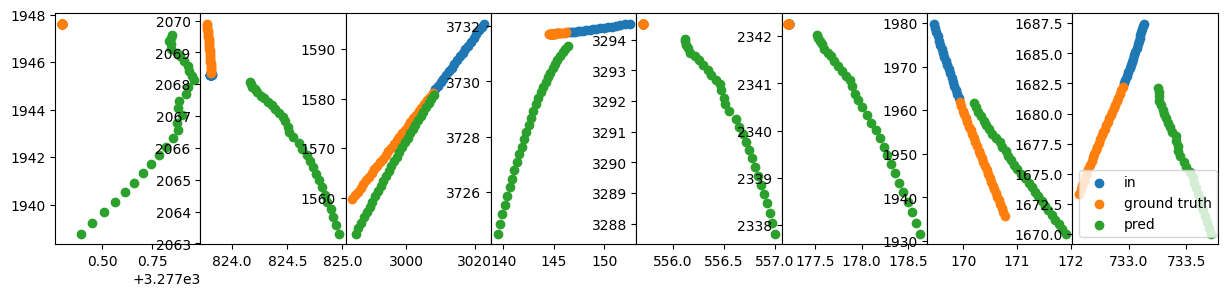

In [ ]:
#agent_id=1
def show_sample_batch(inp, out, pred):
    """visualize the trajectory for a batch of samples with a randon agent"""
    #inp, out = sample_batch
    #batch_sz = inp.size(0)
    #agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,8, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(8):
        #axs[i].xaxis.set_ticks([])
        #axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])
        axs[i].scatter(pred[i,:,0], pred[i,:,1])
        plt.legend(['in','ground truth','pred'])

        
#for sample_batch in enumerate(test_dataset):
inp = X
out = y

X_ = Tensor(X).to(device)

all_data = torch.zeros([8,19+30,4],dtype=torch.float).to(device)
all_data[:,:19,:] = X_

#testX = my_collate_test([data_test[i]])
#id = np.where(data_test[i]['track_id']==data_test[i]['agent_id'])[0][0]
#data_to_csv = []
for j in range(30):
#testX = testX.float().to(device)
#print(testX.shape)
  #print(all_data.shape)
  outputs = lstm(all_data[:,j:19+j,:])
  #print(outputs.shape)
  all_data[:,j+19:j+20,:]=outputs[:,None,:]
pred = all_data[:,19:,:].detach().cpu().numpy()
"""TODO:
  Deep learning model
  training routine
"""
#print(sample_batch[0].shape)
show_sample_batch(inp, out, pred)


(88, 19, 4)


ValueError: ignored

# prediction

In [ ]:
data_test  = ArgoverseDataset(data_path='val_in/val_in')

In [ ]:
np.where(data_test[0]['track_id']==data_test[0]['agent_id'])[0][0]

3

In [ ]:
def my_collate_test(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    #out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]

    inp = torch.LongTensor(inp).to(device)
    #out = torch.LongTensor(out).to(device)
    return inp

In [ ]:
import csv
import copy

In [ ]:

f1 = open('./sample_submission.csv', newline='')
f = open('./sample_submission1.csv', 'w')
reader = csv.reader(f1)
writer = csv.writer(f)
row1 = next(reader)  # gets the first line
writer.writerow(row1)
f1.close()




with torch.no_grad():
  for i in range(len(data_test)):
    all_data = torch.zeros([1,60,19+30,4],dtype=torch.float).to(device)
    all_data[0,:,:19,:] = my_collate_test([data_test[i]])
    #testX = my_collate_test([data_test[i]])
    id = np.where(data_test[i]['track_id']==data_test[i]['agent_id'])[0][0]
    data_to_csv = []
    for j in range(30):
    #testX = testX.float().to(device)
    #print(testX.shape)
      #print(all_data.shape)
      outputs = lstm(all_data[0:1,id,j:19+j,:])
      #print(outputs.shape)
      all_data[0,id,j+19:j+20,:]=outputs

      #print(outputs.shape)
      data_to_csv.append(float(outputs[0][0].cpu().numpy()))
      data_to_csv.append(float(outputs[0][1].cpu().numpy()))
      #break
      #print(outputs.shape)
    #row = [data_test[i]['scene_idx']]+[(float(outputs[i,0].cpu().numpy()),float(outputs[i,1].cpu().numpy())) for i in range(len(outputs))]
    # open the file in the write mode
    # write a row to the csv file
    assert len(data_to_csv)==60
    row = [data_test[i]['scene_idx']]+data_to_csv
    writer.writerow(row)
    #print(row)
    #break
# close the file
f.close()

<ipython-input-18-386aa8c3eb3e>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  inp = torch.LongTensor(inp).to(device)


In [ ]:
val_loss_overall = [i.cpu() for i in val_loss_overall]

[]

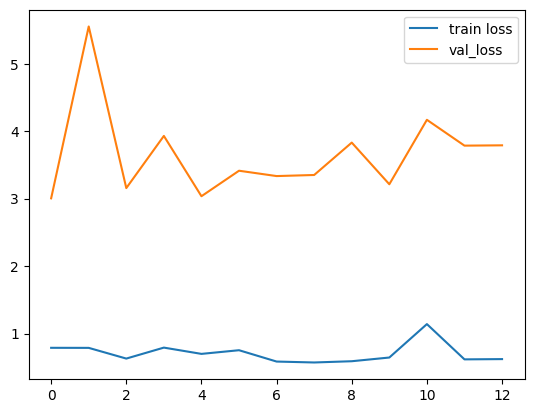

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_overall)
plt.plot(val_loss_overall)
plt.legend(['train loss', 'val_loss'])
plt.plot()

In [ ]:
!cp ./weights_MLP.w ./drive/MyDrive/CSE251B/

In [ ]:
! cp ./sample_submission1.csv ./drive/MyDrive/CSE251B/